In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from factor_analyzer import FactorAnalyzer
from sklearn.linear_model import LinearRegression
from tqdm import tqdm

## 数据准备

In [2]:
df1=pd.read_csv('data/stock_profit.csv')[['code','npMargin','netProfit','MBRevenue','epsTTM','totalShare','liqaShare']]
df2=pd.read_csv('data/stock_growth.csv')[['code','YOYEquity','YOYEPSBasic','YOYNI']]
df3=pd.read_csv('data/stock_balance.csv')[['code','liabilityToAsset','currentRatio','assetToEquity','YOYLiability']]
df4=pd.read_csv('data/stock_dupont.csv')[['code','dupontAssetTurn']]
df5=pd.read_csv('data/stock_industry.csv', encoding='GBK')[['code','code_name','industry']]
df6=pd.read_csv('data/stock_k_data(2024_01_02).csv')[['code','open','volume']]

In [3]:
df=pd.merge(df1,df2,on='code')
df=pd.merge(df,df3,on='code')
df=pd.merge(df,df4,on='code')
df=pd.merge(df,df5,on='code')
df=pd.merge(df,df6,on='code')
df=df[df['industry']=='机械设备']
df=df.dropna().reset_index(drop=True)
print(df.shape,df.columns)
df.head(2)
# df.to_csv('./data/merged.csv')

(470, 19) Index(['code', 'npMargin', 'netProfit', 'MBRevenue', 'epsTTM', 'totalShare',
       'liqaShare', 'YOYEquity', 'YOYEPSBasic', 'YOYNI', 'liabilityToAsset',
       'currentRatio', 'assetToEquity', 'YOYLiability', 'dupontAssetTurn',
       'code_name', 'industry', 'open', 'volume'],
      dtype='object')


,code,npMargin,netProfit,MBRevenue,epsTTM,totalShare,liqaShare,YOYEquity,YOYEPSBasic,YOYNI,liabilityToAsset,currentRatio,assetToEquity,YOYLiability,dupontAssetTurn,code_name,industry,open,volume
0,sh.600031,0.062907,4.606157e+09,7.152143e+10,0.533542,8.485740e+09,8.464216e+09,0.045954,0.053388,0.041606,0.542514,1.794233,2.185859,-0.116326,0.477608,三一重工,机械设备,13.79,36039073.0
1,sh.600169,0.019648,1.644742e+08,8.317862e+09,0.054715,3.380982e+09,2.563955e+09,0.027315,-0.149691,-0.283786,0.796855,1.349245,4.922582,0.013524,0.263104,太原重工,机械设备,2.36,20202679.0


In [4]:
columns=['npMargin', 'netProfit', 'epsTTM', 'totalShare','liqaShare','YOYEquity','MBRevenue','YOYNI',
       'YOYEPSBasic', 'liabilityToAsset', 'currentRatio', 'assetToEquity',
       'YOYLiability', 'dupontAssetTurn']
X = df[columns]
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X),columns = X.columns)

In [5]:
def remove_outliers(series):
    mean = series.mean()
    std = series.std()
    threshold = 3  # 可调整阈值
    return abs(series - mean) <= threshold * std
outliers=X[-X.apply(remove_outliers).all(axis=1)]
X=X[X.apply(remove_outliers).all(axis=1)]

## 因子分析

In [6]:
n_factors = 5  # 指定要提取的因子数量，可以根据需要调整
rotation_method = 'varimax'  # 指定旋转方法，可以根据需要调整
fa = FactorAnalyzer(n_factors, rotation=rotation_method)
fa.fit(X)
loadings = fa.loadings_
fa.get_factor_variance()[2]

array([0.18302638, 0.36235213, 0.51514547, 0.65301002, 0.7004462 ])

In [7]:
fa.loadings_

array([[-0.00593785, -0.34845946,  0.77246218,  0.21708846, -0.0613365 ],
       [ 0.45702233, -0.07552346,  0.61353106,  0.01911303,  0.36552329],
       [-0.01204234, -0.11305038,  0.84675407,  0.12921696,  0.18993714],
       [ 0.95179338,  0.13001725, -0.11215338,  0.01177848, -0.06487078],
       [ 0.9205402 ,  0.15927002, -0.13942356,  0.01903883, -0.05221856],
       [-0.07256808, -0.03398508,  0.40761474,  0.11869959,  0.08464663],
       [ 0.69899204,  0.25618684,  0.20237238, -0.0306696 ,  0.37944364],
       [ 0.00417092, -0.01230721,  0.18489131,  0.97777038,  0.07167985],
       [ 0.0162333 , -0.02546567,  0.18364775,  0.94095788,  0.05257554],
       [ 0.16682088,  0.98540674, -0.1115528 , -0.02557443,  0.11903101],
       [-0.1339319 , -0.69753654,  0.18575397,  0.02791863, -0.24872117],
       [ 0.19932449,  0.8536743 , -0.09942439,  0.01278637,  0.01408157],
       [-0.1425925 ,  0.21913586,  0.2537207 , -0.0314521 , -0.07937791],
       [ 0.006927  ,  0.16257382,  0.1

In [8]:
columns

['npMargin',
 'netProfit',
 'epsTTM',
 'totalShare',
 'liqaShare',
 'YOYEquity',
 'MBRevenue',
 'YOYNI',
 'YOYEPSBasic',
 'liabilityToAsset',
 'currentRatio',
 'assetToEquity',
 'YOYLiability',
 'dupontAssetTurn']

In [9]:
factor_scores=fa.transform(X)
X_1=pd.DataFrame(data=factor_scores, columns=[f'Factor{i+1}' for i in range(n_factors)])
X_1

,Factor1,Factor2,Factor3,Factor4,Factor5
0,3.867077,1.107939,-0.391358,0.106066,-2.610687
1,-0.163110,0.410117,-0.382379,0.032345,1.009829
2,-0.623828,0.932956,0.429320,0.035131,0.669923
3,-0.340904,-0.537640,-2.812880,0.028216,0.858318
4,6.694754,0.661250,-0.196999,0.077318,-0.034076
...,...,...,...,...,...
402,-0.739132,0.395493,-0.273225,-0.527171,-0.194078
403,-0.399880,-1.408761,-0.299015,-0.235750,-0.294539
404,-0.627751,-0.583068,0.200455,0.419583,-0.021680
405,-0.430778,-1.226608,0.268232,-0.481744,-0.742348


## Kmeans 聚类

100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


Text(0.5, 1.0, 'Silhouette score vs Number of clusters')

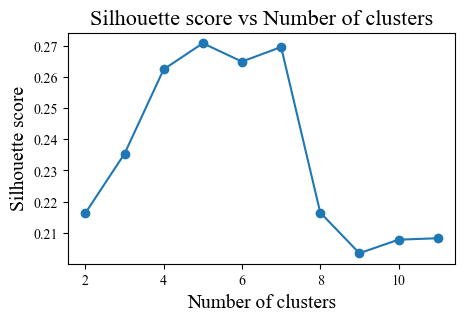

In [11]:
silhouette_avg = []
for i in tqdm(range(10)):
    kmeans = KMeans(n_clusters=i+2,n_init=100)
    kmeans.fit(X_1)
    labels = kmeans.labels_
    silhouette_avg.append(silhouette_score(X_1, labels))

plt.rcParams['font.family'] = 'Times New Roman'
plt.figure(figsize=(5,3))
plt.plot(range(2,12),silhouette_avg,marker='o')
plt.xlabel('Number of clusters',fontsize=14)
plt.ylabel('Silhouette score',fontsize=14)
plt.title('Silhouette score vs Number of clusters', fontsize=16)

In [27]:
kmeans = KMeans(n_clusters=5, n_init=300, random_state=42)
kmeans.fit(X_1)
labels = kmeans.labels_
silhouette_score(X_1, labels)

0.2712525305203179

In [28]:
list(kmeans.cluster_centers_)


[array([-0.20806439, -0.89911153, -0.02579351,  0.09339544, -0.13468109]),
 array([-0.31100061,  0.92344197, -0.02745918,  0.22714467,  0.00647012]),
 array([-0.22168075,  0.39594834, -1.13165036, -3.59692519,  0.01279937]),
 array([ 1.08486615,  0.20460509,  1.39971288, -0.15828711,  1.42344049]),
 array([ 2.91005851,  0.37276559, -0.79660375,  0.28144364, -0.95680816])]

d:\Tools\Codes\anaconda3\lib\site-packages\seaborn\axisgrid.py:1507: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=vector, **plot_kwargs)
d:\Tools\Codes\anaconda3\lib\site-packages\seaborn\axisgrid.py:1507: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=vector, **plot_kwargs)
d:\Tools\Codes\anaconda3\lib\site-packages\seaborn\axisgrid.py:1507: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=vector, **plot_kwargs)
d:\Tools\Codes\anaconda3\lib\site-packages\seaborn\axisgrid.py:1507: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  fu

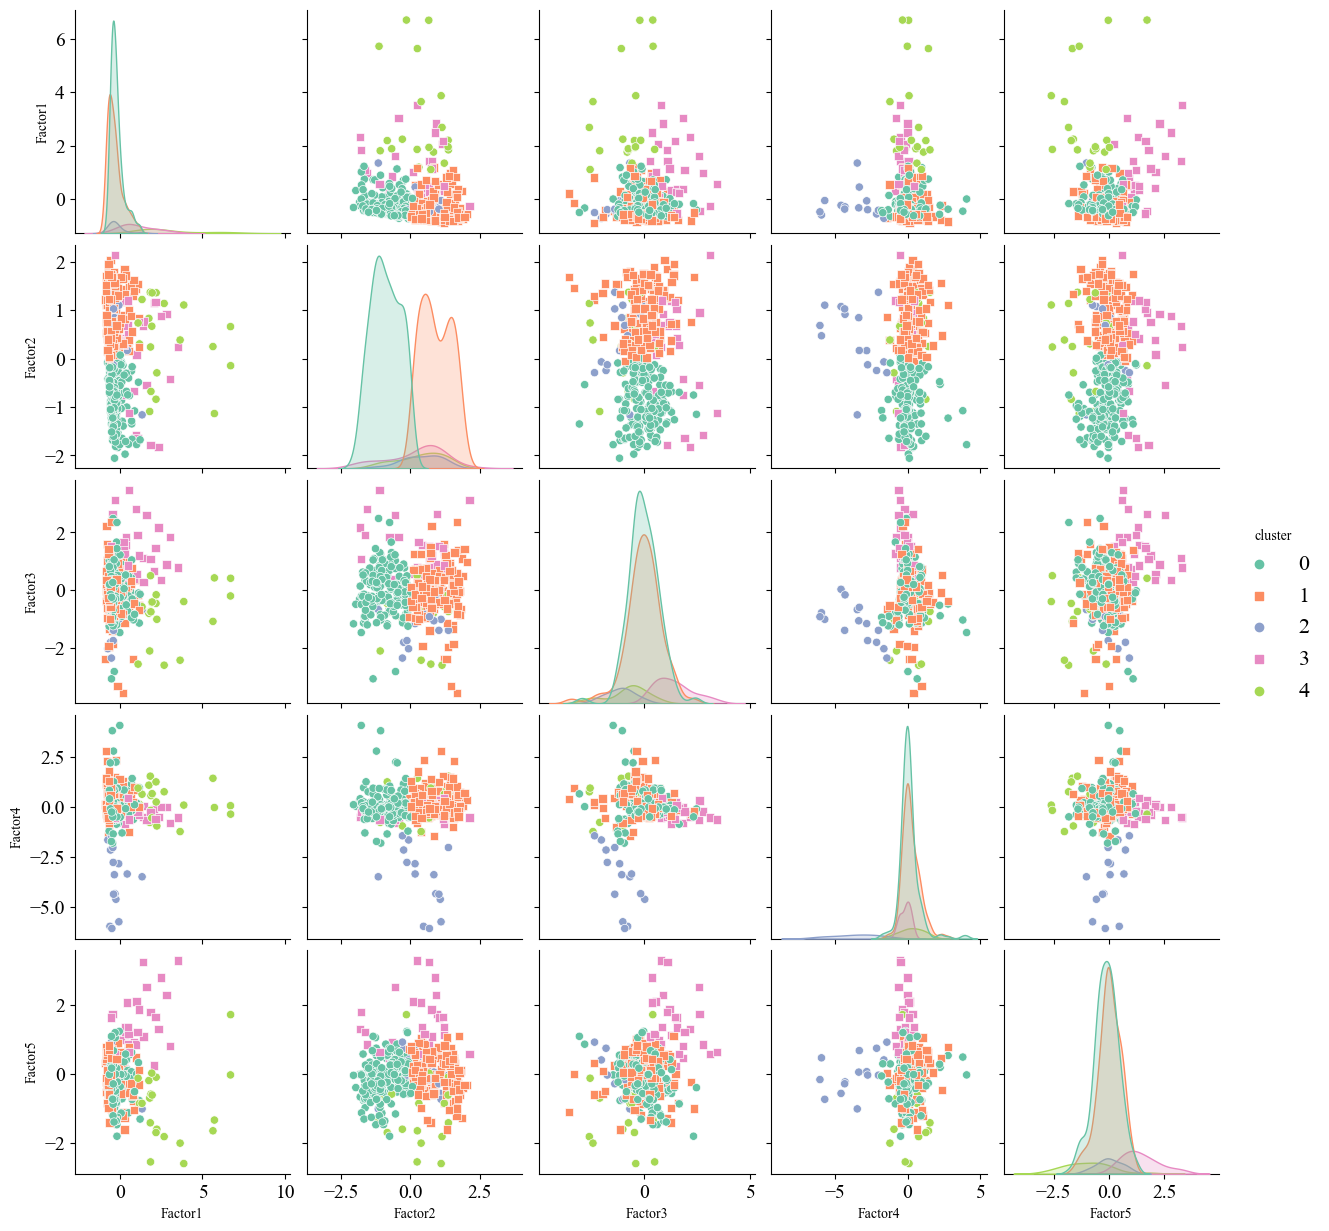

In [29]:
X_vis=X_1.copy()
X_vis['cluster']=labels




# 现在调用sns.pairplot
sns.pairplot(X_vis, diag_kind='kde', hue='cluster', palette='Set2', diag_kws=dict(shade=True), markers=['o', 's'])
# 设置字体大小
# plt.title('Pairplot of the K-means clusters', fontsize=20)
plt.rc('axes', labelsize=25)    # 设置坐标轴标签的字体大小
plt.rc('xtick', labelsize=14)   # 设置x轴刻度标签的字体大小
plt.rc('ytick', labelsize=14)   # 设置y轴刻度标签的字体大小
plt.rc('legend', fontsize=16)   # 设置图例的字体大小
plt.show()


In [16]:
pd.Series(labels).value_counts()

1    184
0    158
2     30
4     20
3     15
dtype: int64

In [17]:
df_merged=pd.merge(df, X_vis, left_index=True, right_index=True,how='inner')
df_merged.reset_index(drop=True,inplace=True)
df_merged.head(2)

,code,npMargin,netProfit,MBRevenue,epsTTM,totalShare,liqaShare,YOYEquity,YOYEPSBasic,YOYNI,...,code_name,industry,open,volume,Factor1,Factor2,Factor3,Factor4,Factor5,cluster
0,sh.600031,0.062907,4.606157e+09,7.152143e+10,0.533542,8.485740e+09,8.464216e+09,0.045954,0.053388,0.041606,...,三一重工,机械设备,13.79,36039073.0,3.867077,1.107939,-0.391358,0.106066,-2.610687,4
1,sh.600169,0.019648,1.644742e+08,8.317862e+09,0.054715,3.380982e+09,2.563955e+09,0.027315,-0.149691,-0.283786,...,太原重工,机械设备,2.36,20202679.0,-0.163110,0.410117,-0.382379,0.032345,1.009829,0


## 多元线性回归

In [18]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# 假设df_merged是一个包含回归特征和目标变量的DataFrame
X = df_merged[columns]
y = df_merged['open']

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 初始化并拟合岭回归模型
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)

# 进行预测
y_pred_train = ridge.predict(X_train)
y_pred_test = ridge.predict(X_test)

# 评估模型
train_mse = mean_squared_error(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, y_pred_test)

print(f'Train MSE: {train_mse}')
print(f'Test MSE: {test_mse}')


Train MSE: 299.1110209931499
Test MSE: 266.1894037071635


d:\Tools\Codes\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=2.20959e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


In [19]:
from sklearn.linear_model import RidgeCV

# 使用交叉验证选择最佳alpha
alphas = [0.1, 1.0, 10.0, 100.0,200,300,400,500]
ridge_cv = RidgeCV(alphas=alphas, cv=5)
ridge_cv.fit(X_train, y_train)

# 输出最佳alpha
print(f'Best alpha: {ridge_cv.alpha_}')
y_pred_cv = ridge_cv.predict(X_test)
test_mse_cv = mean_squared_error(y_test, y_pred_cv)
print(f'Test MSE with RidgeCV: {test_mse_cv}')


Best alpha: 100.0
Test MSE with RidgeCV: 428.7686255211748


d:\Tools\Codes\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=1.1644e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
d:\Tools\Codes\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=1.28833e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
d:\Tools\Codes\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=1.15769e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
d:\Tools\Codes\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=3.70827e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
d:\Tools\Codes\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:211

In [20]:
from sklearn.linear_model import Ridge
X = df_merged[columns]
y = df_merged['open']
ridge = Ridge(alpha=100.0)
ridge.fit(X, y)
y_pred = ridge.predict(X)

d:\Tools\Codes\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=7.89979e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


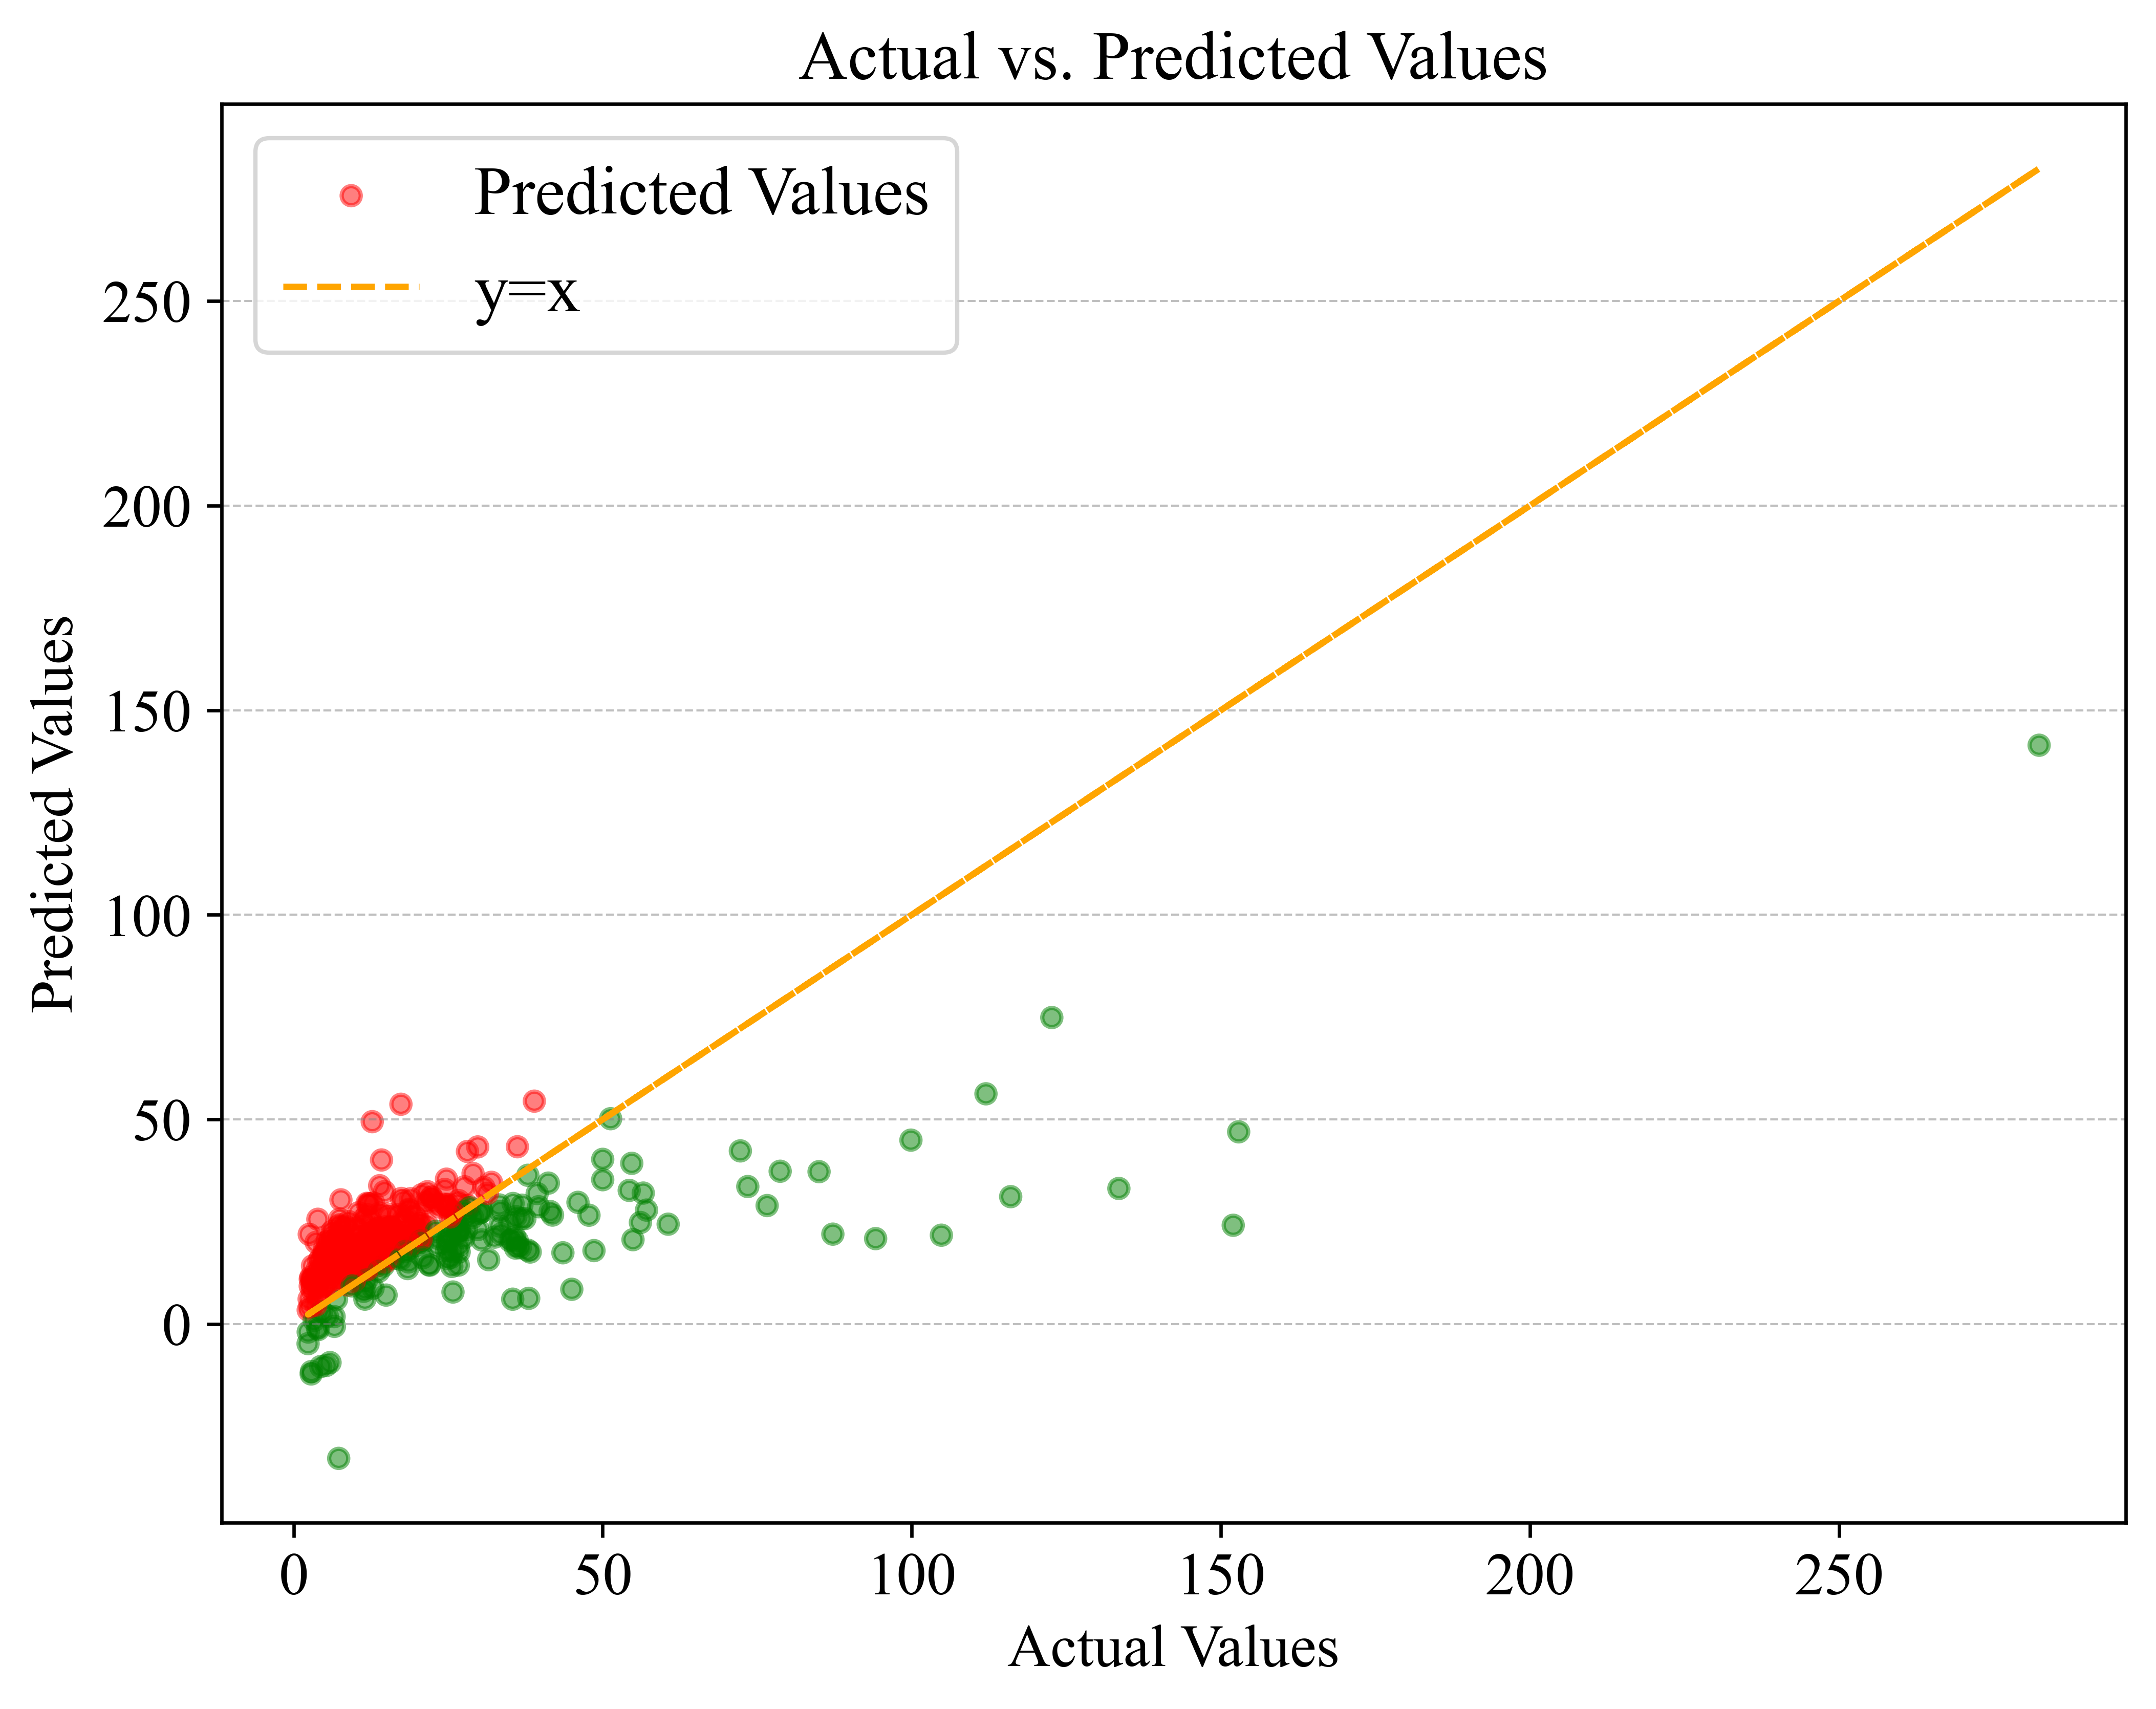

In [21]:
y_pred = ridge_cv.predict(X)
plt.figure(figsize=(8,6),dpi=600)
plt.scatter(df_merged['open'], y_pred, label='Predicted Values', s=20, alpha=0.5, color=['red' if y_pred[i] > df_merged['open'][i] else 'green' for i in range(len(y_pred))])
plt.plot(df_merged['open'], df_merged['open'], color='orange', linestyle='--', label='y=x')
plt.grid(axis='y', color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

plt.xlabel('Actual Values', fontsize=14)
plt.ylabel('Predicted Values', fontsize=14)
plt.title('Actual vs. Predicted Values', fontsize=16)
plt.legend()
plt.show()


## 定义潜力股:  
1. 股票的预测价格高于实际价格 
2. 股票的收益整体是正的  
排名：股票收益率* residual

In [38]:
df_merged['predicted_open']=y_pred
df_merged['residual']=df_merged['predicted_open']-df_merged['open']
stock_candidate=df_merged[(df_merged['residual']>0)&(df_merged['epsTTM']>0)]
stock_candidate['ranking']=stock_candidate['residual']*stock_candidate['epsTTM']
stock_candidate=stock_candidate.sort_values(by='ranking',ascending=False)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_32536\849425433.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_candidate['ranking']=stock_candidate['residual']*stock_candidate['epsTTM']


In [39]:
stock_candidate['code_name']

172     高测股份
293     凌霄泵业
238     杰瑞股份
258    *ST天沃
259     豪迈科技
       ...  
341     三丰智能
389     优德精密
1       太原重工
158     明志科技
358     宝色股份
Name: code_name, Length: 225, dtype: object

## Compare the result to the tempory stock data

In [40]:
df_ref=pd.read_csv('data/stock_k_data(2024_04_01).csv')[['code','open']]
df_ref=pd.merge(df_merged[['code','open','code_name']],df_ref,on='code',how='inner')
print(df_ref.shape,df_ref.columns)
df_ref.head(2)

(407, 4) Index(['code', 'open_x', 'code_name', 'open_y'], dtype='object')


,code,open_x,code_name,open_y
0,sh.600031,13.79,三一重工,14.65
1,sh.600169,2.36,太原重工,2.24


In [41]:
mean=(df_ref['open_y']-df_ref['open_x']).mean()
mean

-2.152678132678133

In [50]:
# df_ref[df_ref['code'] in stock_candidate['code'][:10]]
top_df=df_ref[df_ref['code'].isin(stock_candidate['code'][:10])]
(top_df['open_y']-top_df['open_x']).mean()

0.2960000000000001

In [44]:
top_df

,code,open_x,code_name,open_y
13,sh.600499,10.51,科达制造,10.55
25,sh.600835,11.88,上海机电,12.10
66,sh.603298,24.73,杭叉集团,27.60
81,sh.603611,18.93,诺力股份,19.22
129,sh.688057,14.22,金达莱,11.51
172,sh.688556,38.94,高测股份,30.95
238,sz.002353,28.12,杰瑞股份,30.25
258,sz.002564,3.92,*ST天沃,3.89
259,sz.002595,29.78,豪迈科技,36.10
293,sz.002884,17.36,凌霄泵业,19.18
